In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import to_categorical
import numpy as np

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [2]:
# load dataset
dataset = read_csv('../../data/pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
lbl_encoder = LabelEncoder()
values[:,4] = lbl_encoder.fit_transform(values[:,4])
onehot_encoded = to_categorical(values[:,4])
values = np.hstack((values, onehot_encoded))
values = np.delete(values, 3, 1)
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
n_hours = 3
n_features = 11
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)

(43797, 44)


In [3]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

(8760, 33) 8760 (8760,)


In [4]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 3, 11) (8760,) (35037, 3, 11) (35037,)


Epoch 1/50
122/122 - 3s - loss: 0.0569 - val_loss: 0.0650 - 3s/epoch - 24ms/step
Epoch 2/50
122/122 - 1s - loss: 0.0318 - val_loss: 0.0503 - 774ms/epoch - 6ms/step
Epoch 3/50
122/122 - 1s - loss: 0.0224 - val_loss: 0.0425 - 791ms/epoch - 6ms/step
Epoch 4/50
122/122 - 1s - loss: 0.0214 - val_loss: 0.0322 - 722ms/epoch - 6ms/step
Epoch 5/50
122/122 - 1s - loss: 0.0205 - val_loss: 0.0251 - 692ms/epoch - 6ms/step
Epoch 6/50
122/122 - 1s - loss: 0.0202 - val_loss: 0.0247 - 685ms/epoch - 6ms/step
Epoch 7/50
122/122 - 1s - loss: 0.0194 - val_loss: 0.0223 - 702ms/epoch - 6ms/step
Epoch 8/50
122/122 - 1s - loss: 0.0193 - val_loss: 0.0210 - 729ms/epoch - 6ms/step
Epoch 9/50
122/122 - 1s - loss: 0.0187 - val_loss: 0.0192 - 686ms/epoch - 6ms/step
Epoch 10/50
122/122 - 1s - loss: 0.0185 - val_loss: 0.0201 - 657ms/epoch - 5ms/step
Epoch 11/50
122/122 - 1s - loss: 0.0180 - val_loss: 0.0185 - 651ms/epoch - 5ms/step
Epoch 12/50
122/122 - 1s - loss: 0.0177 - val_loss: 0.0176 - 672ms/epoch - 6ms/step
Epo

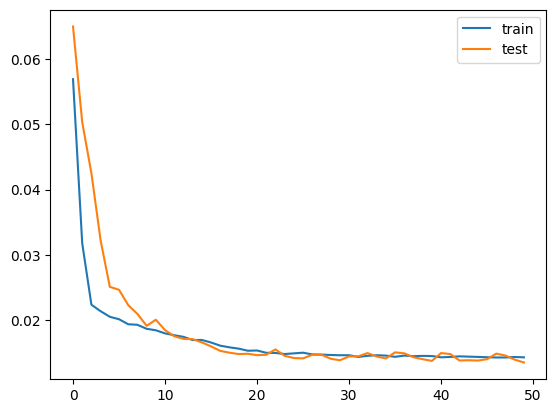

In [5]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [6]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -10:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -10:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

1095/1095 [==============================] - 2s 956us/step
Test RMSE: 26.221
